<a href="https://colab.research.google.com/github/cr0wley-zz/nmt/blob/main/Ablation_Unidirection_(GRU).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Which GPU is being used?
! nvidia-smi

Mon Mar  1 19:38:04 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     7W /  75W |      0MiB /  7611MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Introduction
This notebook holds our experiments on Neural Machine Translation with Attention mechanism.
Some notes:
- Bahdanau
- Luong
- Softmax vs Sigmoid
- Wrapping the function with `model.fit`

We have taken heavy inspiration from the official [TensorFlow guide](https://www.tensorflow.org/tutorials/text/nmt_with_attention).
> A note for the readers: We will be importing packages as we go along. You will not be looking at all the imports at one place.

In [2]:
import tensorflow as tf
from tensorflow.keras import layers as L

In [4]:
tf.random.set_seed(7)

# Utilities And Downloads

We use `tf.keras.utils.get_file` to download the English to Spanish dataset hosted by Google. We define the file name where the script will save the dataset

In [5]:
# Download the file
path_to_zip = tf.keras.utils.get_file(
    'spa-eng.zip',
    origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
    extract=True
)

print(f"[INFO] PATH TO ZIP: {path_to_zip}")

2646016/2638744 [==============================] - 0s 0us/step
[INFO] PATH TO ZIP: /root/.keras/datasets/spa-eng.zip


In [6]:
import os

In [7]:
path_to_file = os.path.dirname(path_to_zip)+"/spa-eng/spa.txt"

print(f"[INFO] PATH TO FILE: {path_to_file}")

[INFO] PATH TO FILE: /root/.keras/datasets/spa-eng/spa.txt


# Cleaner functions



In [8]:
import unicodedata
import re

In [9]:
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
    if unicodedata.category(c) != 'Mn')

In [10]:
def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())
    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)
    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)
    w = w.strip()
    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    w = '<start> ' + w + ' <end>'
    return w

In [11]:
en_sentence = u"May I borrow this book?"
sp_sentence = u"¿Puedo tomar prestado este libro?"
print(preprocess_sentence(en_sentence))
print(preprocess_sentence(sp_sentence).encode('utf-8'))

<start> may i borrow this book ? <end>
b'<start> \xc2\xbf puedo tomar prestado este libro ? <end>'


In [12]:
import io

In [13]:
def create_dataset(path, num_examples):
    lines = io.open(path, encoding='UTF-8').read().strip().split('\n')

    word_pairs = [[preprocess_sentence(w) for w in l.split('\t')]  for l in lines[:num_examples]]

    return zip(*word_pairs)

In [14]:
en, sp = create_dataset(path_to_file, None)
print(en[-1])
print(sp[-1])

<start> if you want to sound like a native speaker , you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo . <end>
<start> si quieres sonar como un hablante nativo , debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un musico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado . <end>


In [15]:
def tokenize(lang):
    lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
        filters='')
    lang_tokenizer.fit_on_texts(lang)

    tensor = lang_tokenizer.texts_to_sequences(lang)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(
        tensor,
        padding='post')

    return tensor, lang_tokenizer

In [16]:
def load_dataset(path, num_examples=None):
    # creating cleaned input, output pairs
    inp_lang, targ_lang = create_dataset(path , num_examples)

    input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
    target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [17]:
num_examples = 40000
(input_tensor,target_tensor,inp_lang,targ_lang) = load_dataset(path_to_file,num_examples)

# Calculate max_length of the target tensors
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]

In [19]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test 
    = train_test_split(X, y, test_size=0.2, random_state=1)

 X_train, X_val, y_train, y_val 
    = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

In [20]:
# Creating training and validation sets using an 80-20 split
(input_tensor_train,input_tensor_val,target_tensor_train,target_tensor_val) = train_test_split(input_tensor,target_tensor,test_size=0.2)
(input_tensor_train,input_tensor_test,target_tensor_train,target_tensor_test) = train_test_split(input_tensor,target_tensor,test_size=0.1)

# Show length
print(len(input_tensor_train),len(target_tensor_train),len(input_tensor_val),len(target_tensor_val),len(input_tensor_test),len(target_tensor_test))

36000 36000 8000 8000 4000 4000


In [22]:
def convert(lang, tensor):
    for t in tensor:
        if t!=0:
            print ("%d ----> %s" % (t, lang.index_word[t]))

In [23]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <start>
182 ----> nobody
438 ----> helped
68 ----> her
3 ----> .
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
83 ----> nadie
13 ----> la
572 ----> ayudo
3 ----> .
2 ----> <end>


In [24]:
# GLOBAL VARIABLES
BUFFER_SIZE_TRAIN = len(input_tensor_train)
BUFFER_SIZE_VAL = len(input_tensor_val)
BATCH_SIZE = 1000
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 512
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

train_ds = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE_TRAIN)
train_ds = train_ds.batch(BATCH_SIZE, drop_remainder=True)

val_ds = tf.data.Dataset.from_tensor_slices((input_tensor_val, target_tensor_val)).shuffle(BUFFER_SIZE_VAL)
val_ds = val_ds.batch(BATCH_SIZE, drop_remainder=True)

In [26]:
# check the shape
for en,sp in train_ds.take(1):
    print(sp.shape)
    print(en.shape)

(1000, 16)
(1000, 12)


In [27]:
class Encoder(tf.keras.Model):
  def __init__(self,
               vocab_size,
               embedding_dim,
               enc_units,
               batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = L.Embedding(vocab_size, embedding_dim)
    self.gru = L.GRU(self.enc_units,
                     return_sequences=True,
                     return_state=True,
                     recurrent_initializer='glorot_uniform')
    #self.bidirection = L.Bidirectional(self.gru, merge_mode='concat' )

  def call(self,
           x,
           hidden_fd):
    x = self.embedding(x)
    #output, fd_state, bd_state = self.bidirection(x, initial_state = [hidden_fd, hidden_bd])
    output, fd_state = self.gru(x, initial_state = [hidden_fd])
    return output, fd_state

  def initialize_hidden_state(self):
    #return [tf.zeros((self.batch_sz, self.enc_units)) for i in range(2)]
    return tf.zeros((self.batch_sz, self.enc_units))

In [28]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
initial_fwd = encoder.initialize_hidden_state()
for en, sp in train_ds.take(1):
    #sample_output, sample_hidden_fwd, sample_hidden_bck = encoder(en, initial_fwd, initial_bck)
    sample_output, sample_hidden_fwd = encoder(en, initial_fwd)
    print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
    print ('Encoder Hidden FWD state shape: (batch size, units) {}'.format(sample_hidden_fwd.shape))
    #print ('Encoder Hidden FWD state shape: (batch size, units) {}'.format(sample_hidden_bck.shape))

Encoder output shape: (batch size, sequence length, units) (1000, 12, 1024)
Encoder Hidden FWD state shape: (batch size, units) (1000, 1024)


In [29]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = L.Dense(units)
    self.W2 = L.Dense(units)
    self.V = L.Dense(1)

  def call(self, query, values):
    # Query Decoder Hidden state, Values belongs is the Encoder output
    # query hidden state shape == (batch_size, hidden size)
    # query_with_time_axis shape == (batch_size, 1, hidden size)
    # values shape == (batch_size, max_len, hidden size)
    # we are doing this to broadcast addition along the time axis to calculate the score
    query_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(query_with_time_axis) + self.W2(values)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)
    
    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [30]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = L.Embedding(vocab_size, embedding_dim)
    self.gru = L.GRU(self.dec_units,
                     return_sequences=True,
                     return_state=True,
                     recurrent_initializer='glorot_uniform')
    self.fc = L.Dense(vocab_size)
    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)
    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)
    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
    # passing the concatenated vector to the GRU
    output, state = self.gru(x)
    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))
    # output shape == (batch_size, vocab)
    x = self.fc(output)
    return x, state, attention_weights

In [32]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

initial_fwd = encoder.initialize_hidden_state()
for en,sp in train_ds.take(1):
    encoder_output, encoder_hidden_fwd = encoder(en, initial_fwd)
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)
    decoder_output, decoder_hidden, att_weights = decoder(dec_input, encoder_hidden_fwd, encoder_output)

    print ('Decoder output shape: (batch_size, vocab size) {}'.format(decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (1000, 11281)


# Model Class for easier training

In [33]:
for en, sp in val_ds.take(1):
    print(en.shape)
    print(sp.shape)

(1000, 12)
(1000, 16)


In [34]:
class NMT(tf.keras.Model):
    def __init__(self, encoder, decoder):
        super(NMT, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        enc_hidden_fwd = self.encoder.initialize_hidden_state()
        inp, targ = data
        loss = 0
        with tf.GradientTape() as tape:
            enc_output, enc_hidden_fwd = self.encoder(inp, enc_hidden_fwd)
            dec_hidden = enc_hidden_fwd
            dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)
            # Teacher forcing - feeding the target as the next input
            for t in range(1, targ.shape[1]):
                # passing enc_output to the decoder
                predictions, dec_hidden, att_weights = self.decoder(dec_input, dec_hidden, enc_output)
                loss += self.compiled_loss(targ[:, t], predictions)
                # using teacher forcing
                dec_input = tf.expand_dims(targ[:, t], 1)
        batch_loss = (loss / int(targ.shape[1]))
        variables = encoder.trainable_variables + decoder.trainable_variables
        gradients = tape.gradient(loss, variables)
        optimizer.apply_gradients(zip(gradients, variables))
        return {"custom_loss": batch_loss}
    
    def test_step(self, data):
        enc_hidden_fwd = self.encoder.initialize_hidden_state()
        inp, targ = data
        loss = 0
        enc_output, enc_hidden_fwd = self.encoder(inp, enc_hidden_fwd)
        dec_hidden = enc_hidden_fwd
        dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)
        # Teacher forcing - feeding the target as the next input
        for t in range(1, targ.shape[1]):
            # passing enc_output to the decoder
            predictions, dec_hidden, att_weights = self.decoder(dec_input, dec_hidden, enc_output)
            loss += self.compiled_loss(targ[:, t], predictions)
            # using teacher forcing
            dec_input = tf.expand_dims(targ[:, t], 1)
        batch_loss = (loss / int(targ.shape[1]))
        return {"custom_loss": batch_loss}

In [35]:
# Early Stopping to prevent overfitting
es = tf.keras.callbacks.EarlyStopping(monitor="val_custom_loss", patience=5, verbose=2, restore_best_weights=True)

In [36]:
EPOCHS=100
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True,
    reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

main_model = NMT(encoder, decoder)
main_model.compile(loss=loss_function, optimizer=optimizer)

history = main_model.fit(
    train_ds,
    validation_data=val_ds,
    callbacks=[es],
    epochs=EPOCHS)

Epoch 1/100
36/36 [==============================] - 63s 1s/step - custom_loss: 2.2361 - val_custom_loss: 1.8737
Epoch 2/100
36/36 [==============================] - 46s 1s/step - custom_loss: 1.7494 - val_custom_loss: 1.6321
Epoch 3/100
36/36 [==============================] - 47s 1s/step - custom_loss: 1.5874 - val_custom_loss: 1.5217
Epoch 4/100
36/36 [==============================] - 48s 1s/step - custom_loss: 1.4837 - val_custom_loss: 1.4186
Epoch 5/100
36/36 [==============================] - 48s 1s/step - custom_loss: 1.4018 - val_custom_loss: 1.3479
Epoch 6/100
36/36 [==============================] - 48s 1s/step - custom_loss: 1.3180 - val_custom_loss: 1.2710
Epoch 7/100
36/36 [==============================] - 48s 1s/step - custom_loss: 1.2480 - val_custom_loss: 1.2190
Epoch 8/100
36/36 [==============================] - 48s 1s/step - custom_loss: 1.1822 - val_custom_loss: 1.1380
Epoch 9/100
36/36 [==============================] - 48s 1s/step - custom_loss: 1.1215 - val_cus

In [47]:
Score = main_model.evaluate(input_tensor_test, target_tensor_test, batch_size = 1000 )

4/4 [==============================] - 2s 428ms/step - custom_loss: 0.8420


In [48]:
Score

0.873832106590271

# Inference

In [37]:
encoder = main_model.encoder
decoder = main_model.decoder

In [38]:
def evaluate(sentence):
    attention_plot = np.zeros((max_length_targ, max_length_inp))
    sentence = preprocess_sentence(sentence)
    inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],maxlen=max_length_inp,padding='post')
    inputs = tf.convert_to_tensor(inputs)
    
    result = ''
    encoder_hidden_fwd = tf.zeros((1, units))
    #encoder_hidden_bck = tf.zeros((1, units))
    enc_out, enc_hidden_fwd = encoder(inputs, encoder_hidden_fwd)

    dec_hidden = enc_hidden_fwd
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input,dec_hidden,enc_out)
        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()
        predicted_id = tf.argmax(predictions[0]).numpy()
        result += targ_lang.index_word[predicted_id] + ' '
        if targ_lang.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot
        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)
    return result, sentence, attention_plot

In [39]:
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [40]:
def translate(sentence):

    result, sentence, attention_plot = evaluate(sentence)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

Input: <start> how are you ? <end>
Predicted translation: ¿ como estan ustedes ? <end> 


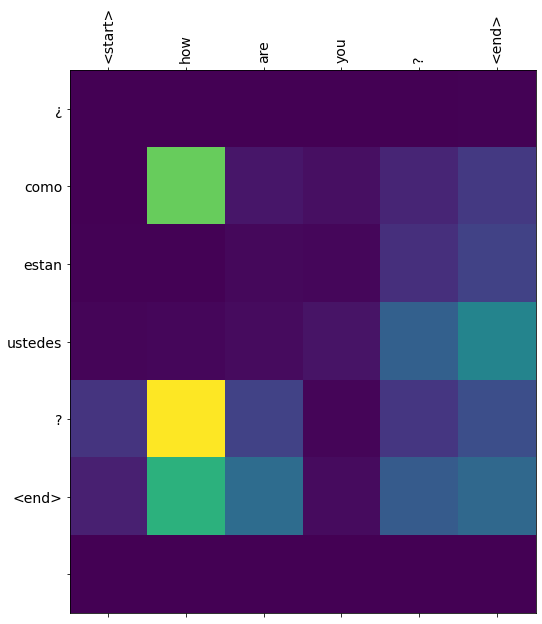

In [42]:
translate(u'how are you?')

Input: <start> i am good . <end>
Predicted translation: se me da bien . <end> 


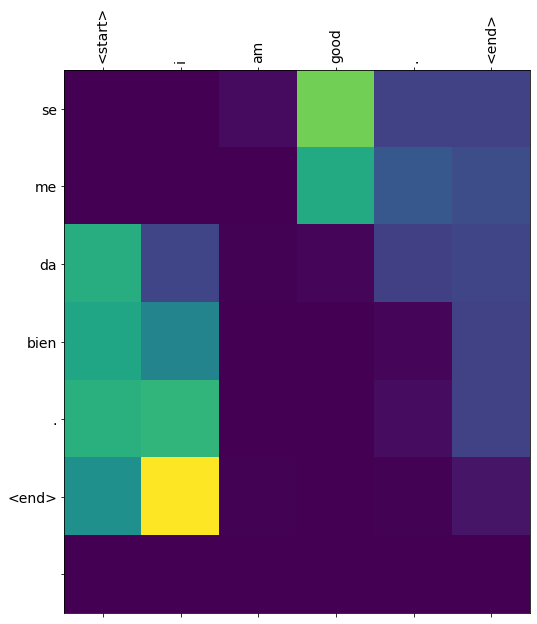

In [43]:
translate(u'i am good.')

Input: <start> i am going to school <end>
Predicted translation: voy a la escuela . <end> 


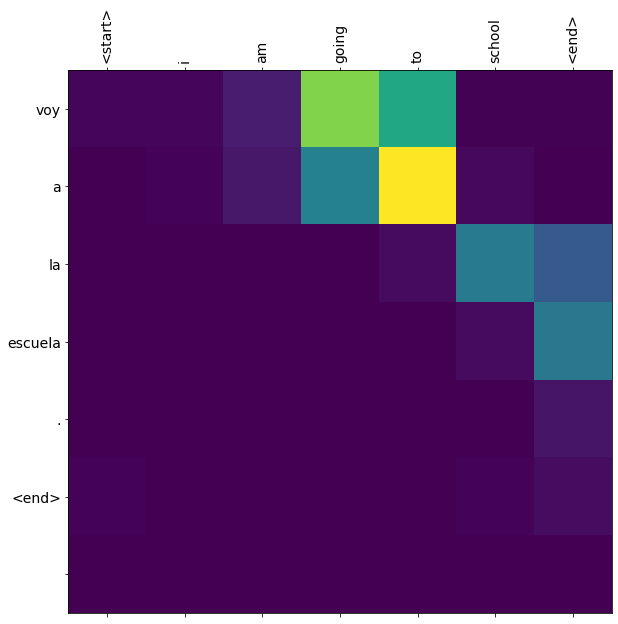

In [ ]:
translate(u'i am going to school')

Input: <start> let us go home now <end>
Predicted translation: dejanos irnos a casa . <end> 


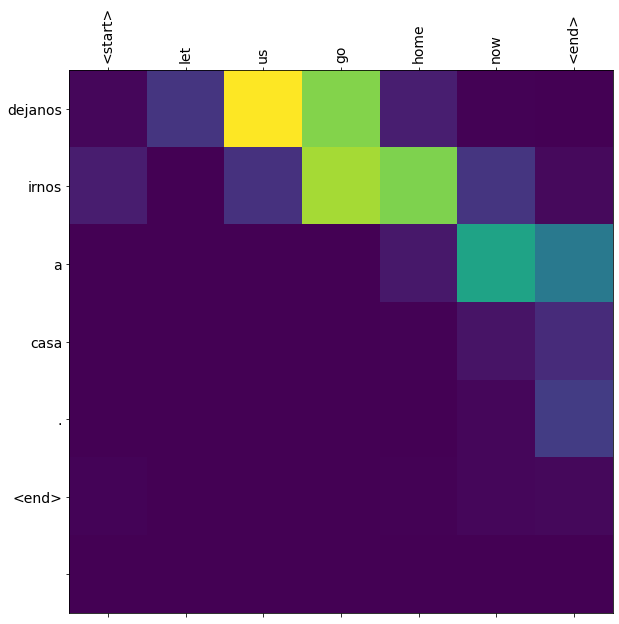

In [ ]:
translate(u'let us go home now')

Input: <start> it is my turn <end>
Predicted translation: es mi turno de verdad . <end> 


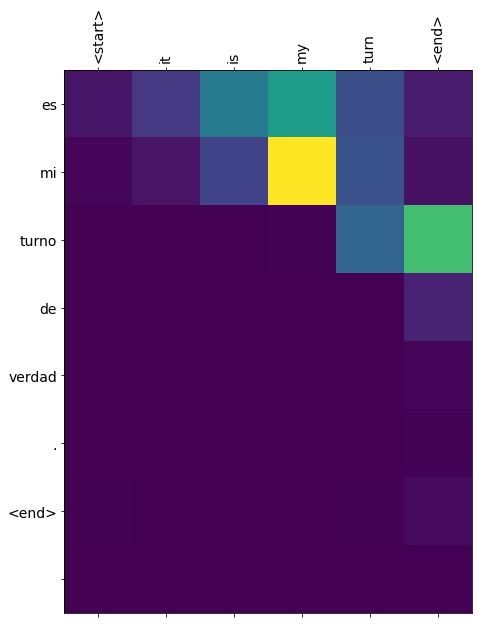

In [ ]:
translate(u'It is my turn')